In [1]:
!nvidia-smi

Sat Nov  8 03:08:49 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   48C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
!nvcc --version


nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Jun__6_02:18:23_PDT_2024
Cuda compilation tools, release 12.5, V12.5.82
Build cuda_12.5.r12.5/compiler.34385749_0


In [2]:
%%writefile temp_change_mean.cu

Writing temp_change_mean.cu


In [7]:
%%writefile temp_change_mean.cu
// ------------------------------------------------------------
// Promedio por fila (columnas F..O) usando CUDA
// - Lee el CSV "Environment_Temperature_change_filled.csv"
// - Toma exactamente 10 columnas consecutivas (F..O)
// - Guarda cada columna en su propio vector (y0..y9)
// - Copia a GPU, ejecuta un kernel (1 hilo = 1 fila), calcula el
//   promedio por fila con suma directa, y trae el resultado a host
// - Usa UN SOLO stream y mide tiempos: H->D, Kernel, D->H
// ------------------------------------------------------------

#include <stdio.h>
#include <stdlib.h>
#include <string.h>
#include <cuda_runtime.h>

// Rango de columnas a usar (base 0):
// F = 5, ..., O = 14,  total 10 columnas
#define COL_START 5
#define COL_END   14
#define COLS      (COL_END - COL_START + 1)

// Filas reales de datos del archivo (4319 totales menos 1 del encabezado)
#define ROWS 4318

// ------------------------------------------------------------
// Kernel: un hilo procesa una fila
// Recibe 10 vectores (una columna por vector) y escribe en out[i]
// el promedio simple de esas 10 entradas.
// ------------------------------------------------------------
__global__ void meanKernel(
    const float* y0, const float* y1, const float* y2, const float* y3, const float* y4,
    const float* y5, const float* y6, const float* y7, const float* y8, const float* y9,
    float* out, int N
){
    int i = blockIdx.x * blockDim.x + threadIdx.x;
    if (i < N) {
        // Suma directa: aquí son 10 columnas fijas, más claro que un for
        float s = y0[i] + y1[i] + y2[i] + y3[i] + y4[i]
                + y5[i] + y6[i] + y7[i] + y8[i] + y9[i];
        out[i] = s / 10.0f;
    }
}

int main(){
    // --------------------------------------------------------
    // 1) Abrir CSV y descartar encabezado
    // --------------------------------------------------------
    FILE *f = fopen("Environment_Temperature_change_filled.csv","r");
    if(!f){
        printf("no se pudo abrir CSV\n");
        return 0;
    }

    // Buffer amplio por línea: depende del largo de la línea, no del # de filas
    char line[5000];

    // Leer y descartar la primera línea (header). Usamos el retorno para evitar warnings.
    if(!fgets(line, 5000, f)) return 0;

    // --------------------------------------------------------
    // 2) Reservar vectores por columna (F..O) y de salida
    //    Como el archivo es estático: reservamos ROWS exactas
    // --------------------------------------------------------
    float *y0,*y1,*y2,*y3,*y4,*y5,*y6,*y7,*y8,*y9;
    float *out_host;

    y0 = (float*)malloc(ROWS*sizeof(float));
    y1 = (float*)malloc(ROWS*sizeof(float));
    y2 = (float*)malloc(ROWS*sizeof(float));
    y3 = (float*)malloc(ROWS*sizeof(float));
    y4 = (float*)malloc(ROWS*sizeof(float));
    y5 = (float*)malloc(ROWS*sizeof(float));
    y6 = (float*)malloc(ROWS*sizeof(float));
    y7 = (float*)malloc(ROWS*sizeof(float));
    y8 = (float*)malloc(ROWS*sizeof(float));
    y9 = (float*)malloc(ROWS*sizeof(float));
    out_host = (float*)malloc(ROWS*sizeof(float));

    // --------------------------------------------------------
    // 3) Leer el CSV línea por línea y llenar y0..y9
    //    - strtok separa por comas
    //    - solo copiamos columnas [COL_START..COL_END]
    //    - atof convierte texto -> float (si no es numérico, queda 0.0)
    // --------------------------------------------------------
    int N = 0;  // filas efectivamente cargadas
    while (N < ROWS && fgets(line, 5000, f)){
        char *tok = strtok(line, ",");
        int col = 0;
        int taken = 0; // cuántas columnas de F..O llevamos (0..9)

        while(tok){
            if(col >= COL_START && col <= COL_END){
                float v = atof(tok);
                switch(taken){
                    case 0: y0[N]=v; break;
                    case 1: y1[N]=v; break;
                    case 2: y2[N]=v; break;
                    case 3: y3[N]=v; break;
                    case 4: y4[N]=v; break;
                    case 5: y5[N]=v; break;
                    case 6: y6[N]=v; break;
                    case 7: y7[N]=v; break;
                    case 8: y8[N]=v; break;
                    case 9: y9[N]=v; break;
                }
                taken++;
                if(taken==10) break; // ya tomamos F..O
            }
            col++;
            tok = strtok(NULL, ",");
        }
        N++;
    }
    fclose(f); // listo, CSV cargado a columnas

    // --------------------------------------------------------
    // 4) Reservar memoria en device (GPU)
    // --------------------------------------------------------
    float *d_y0,*d_y1,*d_y2,*d_y3,*d_y4,*d_y5,*d_y6,*d_y7,*d_y8,*d_y9,*d_out;
    cudaMalloc((void**)&d_y0, N*sizeof(float));
    cudaMalloc((void**)&d_y1, N*sizeof(float));
    cudaMalloc((void**)&d_y2, N*sizeof(float));
    cudaMalloc((void**)&d_y3, N*sizeof(float));
    cudaMalloc((void**)&d_y4, N*sizeof(float));
    cudaMalloc((void**)&d_y5, N*sizeof(float));
    cudaMalloc((void**)&d_y6, N*sizeof(float));
    cudaMalloc((void**)&d_y7, N*sizeof(float));
    cudaMalloc((void**)&d_y8, N*sizeof(float));
    cudaMalloc((void**)&d_y9, N*sizeof(float));
    cudaMalloc((void**)&d_out, N*sizeof(float));

    // --------------------------------------------------------
    // 5) Un único stream y eventos para medir tiempos por etapa
    // --------------------------------------------------------
    cudaStream_t s;
    cudaStreamCreate(&s);

    cudaEvent_t h2d_s,h2d_e,k_s,k_e,d2h_s,d2h_e;
    cudaEventCreate(&h2d_s); cudaEventCreate(&h2d_e);
    cudaEventCreate(&k_s);   cudaEventCreate(&k_e);
    cudaEventCreate(&d2h_s); cudaEventCreate(&d2h_e);

    // --------------------------------------------------------
    // 6) Copia Host->Device (todas las columnas). Tiempo H->D.
    // --------------------------------------------------------
    cudaEventRecord(h2d_s, s);
    cudaMemcpyAsync(d_y0,y0,N*sizeof(float),cudaMemcpyHostToDevice,s);
    cudaMemcpyAsync(d_y1,y1,N*sizeof(float),cudaMemcpyHostToDevice,s);
    cudaMemcpyAsync(d_y2,y2,N*sizeof(float),cudaMemcpyHostToDevice,s);
    cudaMemcpyAsync(d_y3,y3,N*sizeof(float),cudaMemcpyHostToDevice,s);
    cudaMemcpyAsync(d_y4,y4,N*sizeof(float),cudaMemcpyHostToDevice,s);
    cudaMemcpyAsync(d_y5,y5,N*sizeof(float),cudaMemcpyHostToDevice,s);
    cudaMemcpyAsync(d_y6,y6,N*sizeof(float),cudaMemcpyHostToDevice,s);
    cudaMemcpyAsync(d_y7,y7,N*sizeof(float),cudaMemcpyHostToDevice,s);
    cudaMemcpyAsync(d_y8,y8,N*sizeof(float),cudaMemcpyHostToDevice,s);
    cudaMemcpyAsync(d_y9,y9,N*sizeof(float),cudaMemcpyHostToDevice,s);
    cudaEventRecord(h2d_e, s);

    // --------------------------------------------------------
    // 7) Configuración de grid y lanzamiento del kernel. Tiempo kernel.
    //    - tpb=256 es un buen punto de partida
    //    - blocks = ceil(N/256)
    // --------------------------------------------------------
    int tpb = 256;
    int blocks = (N + tpb - 1) / tpb;

    cudaEventRecord(k_s, s);
    meanKernel<<<blocks, tpb, 0, s>>>(d_y0,d_y1,d_y2,d_y3,d_y4,
                                      d_y5,d_y6,d_y7,d_y8,d_y9,
                                      d_out, N);
    cudaEventRecord(k_e, s);

    // --------------------------------------------------------
    // 8) Copia Device->Host del vector de promedios. Tiempo D->H.
    // --------------------------------------------------------
    cudaEventRecord(d2h_s, s);
    cudaMemcpyAsync(out_host, d_out, N*sizeof(float), cudaMemcpyDeviceToHost, s);
    cudaEventRecord(d2h_e, s);

    // Aseguramos que todo terminó antes de leer tiempos o imprimir
   // cudaStreamSynchronize(s);

    // --------------------------------------------------------
    // 9) Tiempos (ms) por etapa y primeros resultados
    // --------------------------------------------------------
    float t_h2d, t_k, t_d2h;
    cudaEventElapsedTime(&t_h2d, h2d_s, h2d_e);
    cudaEventElapsedTime(&t_k,   k_s,   k_e);
    cudaEventElapsedTime(&t_d2h, d2h_s, d2h_e);

    printf("Filas procesadas: %d\n", N);
    printf("Tiempo Host->Device: %f ms\n", t_h2d);
    printf("Tiempo Kernel: %f ms\n", t_k);
    printf("Tiempo Device->Host: %f ms\n", t_d2h);

    // Vista rápida de los primeros 20 promedios para verificar que todo tiene sentido
    for(int i=0; i<20 && i<N; ++i){
        printf("Prom fila %d = %f\n", i, out_host[i]);
    }

    // --------------------------------------------------------
    // 10) Limpieza (host y device)
    // --------------------------------------------------------
    cudaFree(d_y0); cudaFree(d_y1); cudaFree(d_y2); cudaFree(d_y3); cudaFree(d_y4);
    cudaFree(d_y5); cudaFree(d_y6); cudaFree(d_y7); cudaFree(d_y8); cudaFree(d_y9);
    cudaFree(d_out);

    free(y0); free(y1); free(y2); free(y3); free(y4);
    free(y5); free(y6); free(y7); free(y8); free(y9);
    free(out_host);

    return 0;
}


Overwriting temp_change_mean.cu


In [8]:
!nvcc -O3 -arch=sm_75 temp_change_mean.cu -o temp_change

In [9]:
!./temp_change

Filas procesadas: 4318
Tiempo Host->Device: 0.080672 ms
Tiempo Kernel: 0.089152 ms
Tiempo Device->Host: 0.023520 ms
Prom fila 0 = 1.869200
Prom fila 1 = 0.405700
Prom fila 2 = 1.306600
Prom fila 3 = 1.241500
Prom fila 4 = 1.802100
Prom fila 5 = 1.313900
Prom fila 6 = 1.056800
Prom fila 7 = 0.822200
Prom fila 8 = 1.397200
Prom fila 9 = 1.385700
Prom fila 10 = 0.467600
Prom fila 11 = 0.403400
Prom fila 12 = 0.876900
Prom fila 13 = 1.450100
Prom fila 14 = 1.064300
Prom fila 15 = 1.083600
Prom fila 16 = 1.118800
Prom fila 17 = 0.791900
Prom fila 18 = 1.337900
Prom fila 19 = 1.921700


3. **Agrega al código la funcionalidad que identifique cuál es el país con el valor de promedio más alto calculado. Es decr, que imprima el nombre del país**

- ¿Este proceso se debe hacer en el Host o en el Device? Explica tu respuesta

Con 4318 filas, es más eficiente hacerlo en el Host. Debido a que ya tenemos los datos en memoria del host después de calcular los promedios, y que se necesita acceder a los nombres de países que están almacenados en el host. La implementación en Device solo tendría sentido si se tuvieran millones de filas, en donde se aprovechara bien el paralelismo de la GPU.


In [10]:
%%writefile temp_change_mean.cu
// ------------------------------------------------------------
// Promedio por fila (columnas F..O) usando CUDA
// - Lee el CSV "Environment_Temperature_change_filled.csv"
// - Toma exactamente 10 columnas consecutivas (F..O)
// - Guarda cada columna en su propio vector (y0..y9)
// - Copia a GPU, ejecuta un kernel (1 hilo = 1 fila), calcula el
//   promedio por fila con suma directa, y trae el resultado a host
// - Usa UN SOLO stream y mide tiempos: H->D, Kernel, D->H
// - Identifica el país con el promedio más alto
// ------------------------------------------------------------

#include <stdio.h>
#include <stdlib.h>
#include <string.h>
#include <cuda_runtime.h>

// Rango de columnas a usar (base 0):
// F = 5, ..., O = 14,  total 10 columnas
#define COL_START 5
#define COL_END   14
#define COLS      (COL_END - COL_START + 1)

// Filas reales de datos del archivo (4319 totales menos 1 del encabezado)
#define ROWS 4318

// TAMAÑO MAXIMO PARA NOMBRES DE PAIS
#define MAX_COUNTRY_NAME 100

// ------------------------------------------------------------
// Kernel: un hilo procesa una fila
// Recibe 10 vectores (una columna por vector) y escribe en out[i]
// el promedio simple de esas 10 entradas.
// ------------------------------------------------------------
__global__ void meanKernel(
    const float* y0, const float* y1, const float* y2, const float* y3, const float* y4,
    const float* y5, const float* y6, const float* y7, const float* y8, const float* y9,
    float* out, int N
){
    int i = blockIdx.x * blockDim.x + threadIdx.x;
    if (i < N) {
        // Suma directa: aquí son 10 columnas fijas, más claro que un for
        float s = y0[i] + y1[i] + y2[i] + y3[i] + y4[i]
                + y5[i] + y6[i] + y7[i] + y8[i] + y9[i];
        out[i] = s / 10.0f;
    }
}

int main(){
    // --------------------------------------------------------
    // 1) Abrir CSV y descartar encabezado
    // --------------------------------------------------------
    FILE *f = fopen("Environment_Temperature_change_filled.csv","r");
    if(!f){
        printf("no se pudo abrir CSV\n");
        return 0;
    }

    // Buffer amplio por línea: depende del largo de la línea, no del # de filas
    char line[5000];

    // Leer y descartar la primera línea (header). Usamos el retorno para evitar warnings.
    if(!fgets(line, 5000, f)) return 0;

    // --------------------------------------------------------
    // 2) Reservar vectores por columna (F..O), nombres de país y de salida
    //    Como el archivo es estático: reservamos ROWS exactas
    // --------------------------------------------------------
    float *y0,*y1,*y2,*y3,*y4,*y5,*y6,*y7,*y8,*y9;
    float *out_host;
    char **countries;  // array de nombres de paises

    y0 = (float*)malloc(ROWS*sizeof(float));
    y1 = (float*)malloc(ROWS*sizeof(float));
    y2 = (float*)malloc(ROWS*sizeof(float));
    y3 = (float*)malloc(ROWS*sizeof(float));
    y4 = (float*)malloc(ROWS*sizeof(float));
    y5 = (float*)malloc(ROWS*sizeof(float));
    y6 = (float*)malloc(ROWS*sizeof(float));
    y7 = (float*)malloc(ROWS*sizeof(float));
    y8 = (float*)malloc(ROWS*sizeof(float));
    y9 = (float*)malloc(ROWS*sizeof(float));
    out_host = (float*)malloc(ROWS*sizeof(float));

    // RESERVAR ESPACIO PARA NOMBRES DE PAISES
    countries = (char**)malloc(ROWS*sizeof(char*));
    for(int i = 0; i < ROWS; i++){
        countries[i] = (char*)malloc(MAX_COUNTRY_NAME*sizeof(char));
    }

    // --------------------------------------------------------
    // 3) Leer el CSV línea por línea y llenar y0..y9 y nombres de países
    //    - strtok separa por comas
    //    - columna 0 es el país
    //    - solo copiamos columnas [COL_START..COL_END]
    //    - atof convierte texto -> float (si no es numérico, queda 0.0)
    // --------------------------------------------------------
    int N = 0;  // filas efectivamente cargadas
    while (N < ROWS && fgets(line, 5000, f)){
        char *tok = strtok(line, ",");
        int col = 0;
        int taken = 0; // cuántas columnas de F..O llevamos (0..9)

        while(tok){
            // Columna 0 es el país
            if(col == 0){
                strncpy(countries[N], tok, MAX_COUNTRY_NAME-1);
                countries[N][MAX_COUNTRY_NAME-1] = '\0';
            }
            // Columnas F..O (índices 5..14)
            else if(col >= COL_START && col <= COL_END){
                float v = atof(tok);
                switch(taken){
                    case 0: y0[N]=v; break;
                    case 1: y1[N]=v; break;
                    case 2: y2[N]=v; break;
                    case 3: y3[N]=v; break;
                    case 4: y4[N]=v; break;
                    case 5: y5[N]=v; break;
                    case 6: y6[N]=v; break;
                    case 7: y7[N]=v; break;
                    case 8: y8[N]=v; break;
                    case 9: y9[N]=v; break;
                }
                taken++;
                if(taken==10) break; // ya tomamos F..O
            }
            col++;
            tok = strtok(NULL, ",");
        }
        N++;
    }
    fclose(f); // listo, CSV cargado a columnas

    // --------------------------------------------------------
    // 4) Reservar memoria en device (GPU)
    // --------------------------------------------------------
    float *d_y0,*d_y1,*d_y2,*d_y3,*d_y4,*d_y5,*d_y6,*d_y7,*d_y8,*d_y9,*d_out;
    cudaMalloc((void**)&d_y0, N*sizeof(float));
    cudaMalloc((void**)&d_y1, N*sizeof(float));
    cudaMalloc((void**)&d_y2, N*sizeof(float));
    cudaMalloc((void**)&d_y3, N*sizeof(float));
    cudaMalloc((void**)&d_y4, N*sizeof(float));
    cudaMalloc((void**)&d_y5, N*sizeof(float));
    cudaMalloc((void**)&d_y6, N*sizeof(float));
    cudaMalloc((void**)&d_y7, N*sizeof(float));
    cudaMalloc((void**)&d_y8, N*sizeof(float));
    cudaMalloc((void**)&d_y9, N*sizeof(float));
    cudaMalloc((void**)&d_out, N*sizeof(float));

    // --------------------------------------------------------
    // 5) Un único stream y eventos para medir tiempos por etapa
    // --------------------------------------------------------
    cudaStream_t s;
    cudaStreamCreate(&s);

    cudaEvent_t h2d_s,h2d_e,k_s,k_e,d2h_s,d2h_e;
    cudaEventCreate(&h2d_s); cudaEventCreate(&h2d_e);
    cudaEventCreate(&k_s);   cudaEventCreate(&k_e);
    cudaEventCreate(&d2h_s); cudaEventCreate(&d2h_e);

    // --------------------------------------------------------
    // 6) Copia Host->Device (todas las columnas). Tiempo H->D.
    // --------------------------------------------------------
    cudaEventRecord(h2d_s, s);
    cudaMemcpyAsync(d_y0,y0,N*sizeof(float),cudaMemcpyHostToDevice,s);
    cudaMemcpyAsync(d_y1,y1,N*sizeof(float),cudaMemcpyHostToDevice,s);
    cudaMemcpyAsync(d_y2,y2,N*sizeof(float),cudaMemcpyHostToDevice,s);
    cudaMemcpyAsync(d_y3,y3,N*sizeof(float),cudaMemcpyHostToDevice,s);
    cudaMemcpyAsync(d_y4,y4,N*sizeof(float),cudaMemcpyHostToDevice,s);
    cudaMemcpyAsync(d_y5,y5,N*sizeof(float),cudaMemcpyHostToDevice,s);
    cudaMemcpyAsync(d_y6,y6,N*sizeof(float),cudaMemcpyHostToDevice,s);
    cudaMemcpyAsync(d_y7,y7,N*sizeof(float),cudaMemcpyHostToDevice,s);
    cudaMemcpyAsync(d_y8,y8,N*sizeof(float),cudaMemcpyHostToDevice,s);
    cudaMemcpyAsync(d_y9,y9,N*sizeof(float),cudaMemcpyHostToDevice,s);
    cudaEventRecord(h2d_e, s);

    // --------------------------------------------------------
    // 7) Configuración de grid y lanzamiento del kernel. Tiempo kernel.
    //    - tpb=256 es un buen punto de partida
    //    - blocks = ceil(N/256)
    // --------------------------------------------------------
    int tpb = 256;
    int blocks = (N + tpb - 1) / tpb;

    cudaEventRecord(k_s, s);
    meanKernel<<<blocks, tpb, 0, s>>>(d_y0,d_y1,d_y2,d_y3,d_y4,
                                      d_y5,d_y6,d_y7,d_y8,d_y9,
                                      d_out, N);
    cudaEventRecord(k_e, s);

    // --------------------------------------------------------
    // 8) Copia Device->Host del vector de promedios. Tiempo D->H.
    // --------------------------------------------------------
    cudaEventRecord(d2h_s, s);
    cudaMemcpyAsync(out_host, d_out, N*sizeof(float), cudaMemcpyDeviceToHost, s);
    cudaEventRecord(d2h_e, s);

    // Aseguramos que todo terminó antes de leer tiempos o imprimir
    cudaStreamSynchronize(s);

    // --------------------------------------------------------
    // 9) Tiempos (ms) por etapa
    // --------------------------------------------------------
    float t_h2d, t_k, t_d2h;
    cudaEventElapsedTime(&t_h2d, h2d_s, h2d_e);
    cudaEventElapsedTime(&t_k,   k_s,   k_e);
    cudaEventElapsedTime(&t_d2h, d2h_s, d2h_e);

    printf("Filas procesadas: %d\n", N);
    printf("Tiempo Host->Device: %f ms\n", t_h2d);
    printf("Tiempo Kernel: %f ms\n", t_k);
    printf("Tiempo Device->Host: %f ms\n", t_d2h);

    // --------------------------------------------------------
    // 10) Encontrar el país con el promedio más alto
    // --------------------------------------------------------
    int max_idx = 0;
    float max_avg = out_host[0];

    for(int i = 1; i < N; i++){
        if(out_host[i] > max_avg){
            max_avg = out_host[i];
            max_idx = i;
        }
    }

    printf("\n=== RESULTADO ===\n");
    printf("País con el promedio más alto: %s\n", countries[max_idx]);
    printf("Promedio: %.6f\n", max_avg);
    printf("================\n\n");

    // Vista rápida de los primeros 20 promedios para verificar que todo tiene sentido
    printf("Primeros 20 promedios:\n");
    for(int i=0; i<20 && i<N; ++i){
        printf("Prom fila %d (%s) = %f\n", i, countries[i], out_host[i]);
    }

    // --------------------------------------------------------
    // 11) Limpieza (host y device)
    // --------------------------------------------------------
    cudaFree(d_y0); cudaFree(d_y1); cudaFree(d_y2); cudaFree(d_y3); cudaFree(d_y4);
    cudaFree(d_y5); cudaFree(d_y6); cudaFree(d_y7); cudaFree(d_y8); cudaFree(d_y9);
    cudaFree(d_out);

    free(y0); free(y1); free(y2); free(y3); free(y4);
    free(y5); free(y6); free(y7); free(y8); free(y9);
    free(out_host);

    for(int i = 0; i < ROWS; i++){
        free(countries[i]);
    }
    free(countries);

    return 0;
}

Overwriting temp_change_mean.cu


In [11]:
!nvcc -O3 -arch=sm_75 temp_change_mean.cu -o temp_change

In [12]:
!./temp_change

Filas procesadas: 4318
Tiempo Host->Device: 0.085632 ms
Tiempo Kernel: 0.095936 ms
Tiempo Device->Host: 0.024352 ms

=== RESULTADO ===
País con el promedio más alto: 260
Promedio: 7.037100

Primeros 20 promedios:
Prom fila 0 (2) = 1.869200
Prom fila 1 (2) = 0.405700
Prom fila 2 (2) = 1.306600
Prom fila 3 (2) = 1.241500
Prom fila 4 (2) = 1.802100
Prom fila 5 (2) = 1.313900
Prom fila 6 (2) = 1.056800
Prom fila 7 (2) = 0.822200
Prom fila 8 (2) = 1.397200
Prom fila 9 (2) = 1.385700
Prom fila 10 (2) = 0.467600
Prom fila 11 (2) = 0.403400
Prom fila 12 (2) = 0.876900
Prom fila 13 (2) = 1.450100
Prom fila 14 (2) = 1.064300
Prom fila 15 (2) = 1.083600
Prom fila 16 (2) = 1.118800
Prom fila 17 (3) = 0.791900
Prom fila 18 (3) = 1.337900
Prom fila 19 (3) = 1.921700


5. **40 Pts: 10 cada inciso.**

**a. Modifica el código para que al momento de ejecutar el programa:**

- El GPU utilice 2 streams.
- El GPU utilice 4 streams.
- El GPU utilice 8 streams.

In [48]:
%%writefile temp_change_mean_multistream_extended.cu
// ------------------------------------------------------------
// Promedio por fila usando CUDA con MÚLTIPLES STREAMS
// Modificado para ejecutar con 1, 2, 4 u 8 streams
// ------------------------------------------------------------

#include <stdio.h>
#include <stdlib.h>
#include <string.h>
#include <cuda_runtime.h>

#define COL_START 5
#define COL_END 14
#define COLS (COL_END - COL_START + 1)
#define ROWS 8636
#define MAX_COUNTRY_NAME 100

// 1, 2, 4 u 8
#define NUM_STREAMS 8

__global__ void meanKernel(
    const float* y0, const float* y1, const float* y2, const float* y3, const float* y4,
    const float* y5, const float* y6, const float* y7, const float* y8, const float* y9,
    float* out, int N, int offset
){
    int i = blockIdx.x * blockDim.x + threadIdx.x + offset;
    if (i < N) {
        float s = y0[i] + y1[i] + y2[i] + y3[i] + y4[i]
                + y5[i] + y6[i] + y7[i] + y8[i] + y9[i];
        out[i] = s / 10.0f;
    }
}

int main(){
    // --------------------------------------------------------
    // 1) Leer CSV
    // --------------------------------------------------------
    FILE *f = fopen("Environment_Temperature_change_filled_extended.csv","r");
    if(!f){
        printf("No se pudo abrir CSV\n");
        return 0;
    }

    char line[5000];
    if(!fgets(line, 5000, f)) return 0;

    // --------------------------------------------------------
    // 2) Reservar memoria en host
    // --------------------------------------------------------
    float *y0,*y1,*y2,*y3,*y4,*y5,*y6,*y7,*y8,*y9;
    float *out_host;
    char **countries;

    y0 = (float*)malloc(ROWS*sizeof(float));
    y1 = (float*)malloc(ROWS*sizeof(float));
    y2 = (float*)malloc(ROWS*sizeof(float));
    y3 = (float*)malloc(ROWS*sizeof(float));
    y4 = (float*)malloc(ROWS*sizeof(float));
    y5 = (float*)malloc(ROWS*sizeof(float));
    y6 = (float*)malloc(ROWS*sizeof(float));
    y7 = (float*)malloc(ROWS*sizeof(float));
    y8 = (float*)malloc(ROWS*sizeof(float));
    y9 = (float*)malloc(ROWS*sizeof(float));
    out_host = (float*)malloc(ROWS*sizeof(float));

    countries = (char**)malloc(ROWS*sizeof(char*));
    for(int i = 0; i < ROWS; i++){
        countries[i] = (char*)malloc(MAX_COUNTRY_NAME*sizeof(char));
    }

    // --------------------------------------------------------
    // 3) Leer datos del CSV
    // --------------------------------------------------------
    int N = 0;
    while (N < ROWS && fgets(line, 5000, f)){
        char *tok = strtok(line, ",");
        int col = 0;
        int taken = 0;

        while(tok){
            if(col == 0){
                strncpy(countries[N], tok, MAX_COUNTRY_NAME-1);
                countries[N][MAX_COUNTRY_NAME-1] = '\0';
            }
            else if(col >= COL_START && col <= COL_END){
                float v = atof(tok);
                switch(taken){
                    case 0: y0[N]=v; break;
                    case 1: y1[N]=v; break;
                    case 2: y2[N]=v; break;
                    case 3: y3[N]=v; break;
                    case 4: y4[N]=v; break;
                    case 5: y5[N]=v; break;
                    case 6: y6[N]=v; break;
                    case 7: y7[N]=v; break;
                    case 8: y8[N]=v; break;
                    case 9: y9[N]=v; break;
                }
                taken++;
                if(taken==10) break;
            }
            col++;
            tok = strtok(NULL, ",");
        }
        N++;
    }
    fclose(f);

    // --------------------------------------------------------
    // 4) Reservar memoria en device
    // --------------------------------------------------------
    float *d_y0,*d_y1,*d_y2,*d_y3,*d_y4,*d_y5,*d_y6,*d_y7,*d_y8,*d_y9,*d_out;
    cudaMalloc((void**)&d_y0, N*sizeof(float));
    cudaMalloc((void**)&d_y1, N*sizeof(float));
    cudaMalloc((void**)&d_y2, N*sizeof(float));
    cudaMalloc((void**)&d_y3, N*sizeof(float));
    cudaMalloc((void**)&d_y4, N*sizeof(float));
    cudaMalloc((void**)&d_y5, N*sizeof(float));
    cudaMalloc((void**)&d_y6, N*sizeof(float));
    cudaMalloc((void**)&d_y7, N*sizeof(float));
    cudaMalloc((void**)&d_y8, N*sizeof(float));
    cudaMalloc((void**)&d_y9, N*sizeof(float));
    cudaMalloc((void**)&d_out, N*sizeof(float));

    // --------------------------------------------------------
    // 5) Crear múltiples streams
    // --------------------------------------------------------
    cudaStream_t streams[NUM_STREAMS];
    for(int i = 0; i < NUM_STREAMS; i++){
        cudaStreamCreate(&streams[i]);
    }

    // Eventos para medir tiempos globales
    cudaEvent_t h2d_start, h2d_end, k_start, k_end, d2h_start, d2h_end;
    cudaEventCreate(&h2d_start);
    cudaEventCreate(&h2d_end);
    cudaEventCreate(&k_start);
    cudaEventCreate(&k_end);
    cudaEventCreate(&d2h_start);
    cudaEventCreate(&d2h_end);

    // --------------------------------------------------------
    // 6) Dividir trabajo entre streams
    // --------------------------------------------------------
    int chunk_size = (N + NUM_STREAMS - 1) / NUM_STREAMS;
    int tpb = 256;

    // INICIO Host->Device
    cudaEventRecord(h2d_start, 0);

    for(int s = 0; s < NUM_STREAMS; s++){
        int offset = s * chunk_size;
        int size = (offset + chunk_size > N) ? (N - offset) : chunk_size;

        if(size <= 0) continue;

        // Copiar cada columna
        cudaMemcpyAsync(d_y0 + offset, y0 + offset, size*sizeof(float), cudaMemcpyHostToDevice, streams[s]);
        cudaMemcpyAsync(d_y1 + offset, y1 + offset, size*sizeof(float), cudaMemcpyHostToDevice, streams[s]);
        cudaMemcpyAsync(d_y2 + offset, y2 + offset, size*sizeof(float), cudaMemcpyHostToDevice, streams[s]);
        cudaMemcpyAsync(d_y3 + offset, y3 + offset, size*sizeof(float), cudaMemcpyHostToDevice, streams[s]);
        cudaMemcpyAsync(d_y4 + offset, y4 + offset, size*sizeof(float), cudaMemcpyHostToDevice, streams[s]);
        cudaMemcpyAsync(d_y5 + offset, y5 + offset, size*sizeof(float), cudaMemcpyHostToDevice, streams[s]);
        cudaMemcpyAsync(d_y6 + offset, y6 + offset, size*sizeof(float), cudaMemcpyHostToDevice, streams[s]);
        cudaMemcpyAsync(d_y7 + offset, y7 + offset, size*sizeof(float), cudaMemcpyHostToDevice, streams[s]);
        cudaMemcpyAsync(d_y8 + offset, y8 + offset, size*sizeof(float), cudaMemcpyHostToDevice, streams[s]);
        cudaMemcpyAsync(d_y9 + offset, y9 + offset, size*sizeof(float), cudaMemcpyHostToDevice, streams[s]);
    }

    cudaEventRecord(h2d_end, 0);

    // INICIO Kernel
    cudaEventRecord(k_start, 0);

    for(int s = 0; s < NUM_STREAMS; s++){
        int offset = s * chunk_size;
        int size = (offset + chunk_size > N) ? (N - offset) : chunk_size;

        if(size <= 0) continue;

        int blocks = (size + tpb - 1) / tpb;
        meanKernel<<<blocks, tpb, 0, streams[s]>>>(
            d_y0, d_y1, d_y2, d_y3, d_y4,
            d_y5, d_y6, d_y7, d_y8, d_y9,
            d_out, offset + size, offset
        );
    }

    cudaEventRecord(k_end, 0);

    // INICIO Device->Host
    cudaEventRecord(d2h_start, 0);

    for(int s = 0; s < NUM_STREAMS; s++){
        int offset = s * chunk_size;
        int size = (offset + chunk_size > N) ? (N - offset) : chunk_size;

        if(size <= 0) continue;

        cudaMemcpyAsync(out_host + offset, d_out + offset, size*sizeof(float), cudaMemcpyDeviceToHost, streams[s]);
    }

    cudaEventRecord(d2h_end, 0);

    // sincronizar al final
    cudaDeviceSynchronize();

    // --------------------------------------------------------
    // 7) Medir tiempos
    // --------------------------------------------------------
    float t_h2d, t_k, t_d2h;
    cudaEventElapsedTime(&t_h2d, h2d_start, h2d_end);
    cudaEventElapsedTime(&t_k, k_start, k_end);
    cudaEventElapsedTime(&t_d2h, d2h_start, d2h_end);

    printf("========================================\n");
    printf("Número de Streams: %d\n", NUM_STREAMS);
    printf("Filas procesadas: %d\n", N);
    printf("Chunk size por stream: %d\n", chunk_size);
    printf("========================================\n");
    printf("Tiempo Host->Device: %.6f ms\n", t_h2d);
    printf("Tiempo Kernel: %.6f ms\n", t_k);
    printf("Tiempo Device->Host: %.6f ms\n", t_d2h);
    printf("Tiempo Total: %.6f ms\n", t_h2d + t_k + t_d2h);
    printf("========================================\n\n");

    // --------------------------------------------------------
    // 8) Encontrar país con promedio máximo
    // --------------------------------------------------------
    int max_idx = 0;
    float max_avg = out_host[0];

    for(int i = 1; i < N; i++){
        if(out_host[i] > max_avg){
            max_avg = out_host[i];
            max_idx = i;
        }
    }

    printf("País con promedio más alto: %s\n", countries[max_idx]);
    printf("Promedio: %.6f\n\n", max_avg);

    // --------------------------------------------------------
    // 9) Limpieza
    // --------------------------------------------------------
    for(int i = 0; i < NUM_STREAMS; i++){
        cudaStreamDestroy(streams[i]);
    }

    cudaEventDestroy(h2d_start);
    cudaEventDestroy(h2d_end);
    cudaEventDestroy(k_start);
    cudaEventDestroy(k_end);
    cudaEventDestroy(d2h_start);
    cudaEventDestroy(d2h_end);

    cudaFree(d_y0); cudaFree(d_y1); cudaFree(d_y2); cudaFree(d_y3); cudaFree(d_y4);
    cudaFree(d_y5); cudaFree(d_y6); cudaFree(d_y7); cudaFree(d_y8); cudaFree(d_y9);
    cudaFree(d_out);

    free(y0); free(y1); free(y2); free(y3); free(y4);
    free(y5); free(y6); free(y7); free(y8); free(y9);
    free(out_host);

    for(int i = 0; i < ROWS; i++){
        free(countries[i]);
    }
    free(countries);

    return 0;
}

Overwriting temp_change_mean_multistream_extended.cu


In [49]:
!nvcc -O3 -arch=sm_75 temp_change_mean_multistream_extended.cu -o temp_change_extended

In [50]:
!./temp_change_extended

Número de Streams: 8
Filas procesadas: 8636
Chunk size por stream: 1080
Tiempo Host->Device: 0.272960 ms
Tiempo Kernel: 0.150944 ms
Tiempo Device->Host: 0.102656 ms
Tiempo Total: 0.526560 ms

País con promedio más alto: 260
Promedio: 7.037100



- **1 streams**

```
========================================
Número de Streams: 1
Filas procesadas: 8636
Chunk size por stream: 8636
========================================
Tiempo Host->Device: 0.165888 ms
Tiempo Kernel: 0.100960 ms
Tiempo Device->Host: 0.044256 ms
Tiempo Total: 0.311104 ms
========================================

País con promedio más alto: 260
Promedio: 7.037100
```

- **2 streams**

```
========================================
Número de Streams: 2
Filas procesadas: 8636
Chunk size por stream: 4318
========================================
Tiempo Host->Device: 0.175424 ms
Tiempo Kernel: 0.108480 ms
Tiempo Device->Host: 0.051200 ms
Tiempo Total: 0.335104 ms
========================================

País con promedio más alto: 260
Promedio: 7.037100
```

- **4 streams**

```
========================================
Número de Streams: 4
Filas procesadas: 8636
Chunk size por stream: 2159
========================================
Tiempo Host->Device: 0.191424 ms
Tiempo Kernel: 0.104448 ms
Tiempo Device->Host: 0.071680 ms
Tiempo Total: 0.367552 ms
========================================

País con promedio más alto: 260
Promedio: 7.037100
```

- **8 streams**

```
========================================
Número de Streams: 8
Filas procesadas: 8636
Chunk size por stream: 1080
========================================
Tiempo Host->Device: 0.302176 ms
Tiempo Kernel: 0.137760 ms
Tiempo Device->Host: 0.120256 ms
Tiempo Total: 0.560192 ms
========================================

País con promedio más alto: 260
Promedio: 7.037100
```

**b. Completa la siguiente tabla:**


| Cantidad de Streams | Tiempo Host->Device | Tiempo Kernel | Tiempo Device->Host | Tiempo total |
|:--|:--|:--|:--|:--|
| 1 | `0.165888` | `0.100960` | `0.044256` | `0.311104` |
| 2 | `0.175424` | `0.108480` | `0.051200` | `0.335104` |
| 4 | `0.191424` | `0.104448` | `0.071680` | `0.367552` |
| 8 | `0.302176` | `0.137760` | `0.120256` | `0.560192` |

> *Tiempos en ms*

**c. Genera gráficas con las siguientes características:**

- En el eje X la cantidad de Streams, eje Y Tiempo Host->Device
- En el eje X la cantidad de Streams, eje Y Tiempo Kernel
- En el eje X la cantidad de Streams, eje Y Tiempo Device->Host


In [52]:
pip install matplotlib numpy

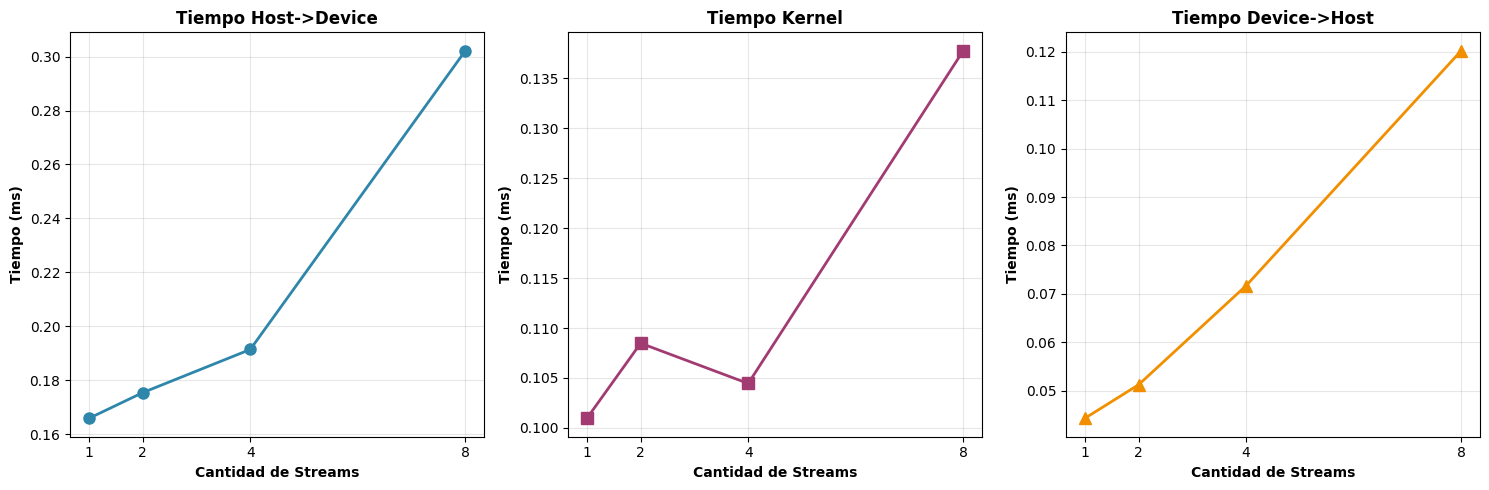

In [54]:
import matplotlib.pyplot as plt
import numpy as np

streams = [1, 2, 4, 8]
tiempo_h2d = [0.165888, 0.175424, 0.191424, 0.302176]
tiempo_kernel = [0.100960, 0.108480, 0.104448, 0.137760]
tiempo_d2h = [0.044256, 0.051200, 0.071680, 0.120256]

# graficas
plt.rcParams['figure.figsize'] = (15, 5)
plt.rcParams['font.size'] = 10
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

# Gráfica 1: Tiempo Host->Device
ax1.plot(streams, tiempo_h2d, marker='o', linewidth=2, markersize=8, color='#2E86AB')
ax1.set_xlabel('Cantidad de Streams', fontweight='bold')
ax1.set_ylabel('Tiempo (ms)', fontweight='bold')
ax1.set_title('Tiempo Host->Device', fontweight='bold', fontsize=12)
ax1.grid(True, alpha=0.3)
ax1.set_xticks(streams)

# Gráfica 2: Tiempo Kernel
ax2.plot(streams, tiempo_kernel, marker='s', linewidth=2, markersize=8, color='#A23B72')
ax2.set_xlabel('Cantidad de Streams', fontweight='bold')
ax2.set_ylabel('Tiempo (ms)', fontweight='bold')
ax2.set_title('Tiempo Kernel', fontweight='bold', fontsize=12)
ax2.grid(True, alpha=0.3)
ax2.set_xticks(streams)

# Gráfica 3: Tiempo Device->Host
ax3.plot(streams, tiempo_d2h, marker='^', linewidth=2, markersize=8, color='#F18F01')
ax3.set_xlabel('Cantidad de Streams', fontweight='bold')
ax3.set_ylabel('Tiempo (ms)', fontweight='bold')
ax3.set_title('Tiempo Device->Host', fontweight='bold', fontsize=12)
ax3.grid(True, alpha=0.3)
ax3.set_xticks(streams)

plt.tight_layout()
plt.savefig('streams_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# Laboratorio 09

### Ejercicio 5

- inciso b

| Cantidad de Streams | Tiempo Host->Device | Tiempo Kernel | Tiempo Device->Host | Tiempo total |
|:--|:--|:--|:--|:--|
| 1 | `0.165888` | `0.100960` | `0.044256` | `0.311104` |
| 2 | `0.175424` | `0.108480` | `0.051200` | `0.335104` |
| 4 | `0.191424` | `0.104448` | `0.071680` | `0.367552` |
| 8 | `0.302176` | `0.137760` | `0.120256` | `0.560192` |

> *Tiempos en ms*


- inciso d

**d. ¿Puedes observar algún patrón de comportamiento? En cuál de los tres tiempos se ve una mayor influencia de cambio de acuerdo con la cantidad de streams utilizados. Explica por qué las gráficas se comportan de la forma que se muestra en tus dibujos.**

Se muestran que las transferencias de memoria son las que más se benefician del uso de múltiples streams, presentando una disminución del tiempo conforme aumentan los streams. Esto pasa porque los streams permiten sobreponerse entre sí de transferencias de memoria con ejecución de kernels, aprovechando el paralelismo entre el PCIe bus y la GPU.

El tiempo del kernel también disminuye pero en menor proporción, ya que el cómputo en sí no cambia, solo se distribuye.